# Smart Beta Portfolio

The Smart Beta strategy in finance is an investment approach that combines elements of both passive and active investing. Unlike traditional passive strategies that track market-capitalization-weighted indexes (like the S&P 500), Smart Beta strategies aim to enhance returns, reduce risk, or improve diversification by weighting assets based on alternative factors or metrics. These factors might include value, size, momentum, volatility, or dividends.

Smart Beta strategies systematically follow rules-based approaches to select and weight assets, and they typically offer a middle ground between purely passive index investing and active stock picking. The goal is to capture specific risk premiums associated with the chosen factors, potentially leading to better risk-adjusted returns compared to traditional market-cap-weighted portfolios.


In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
from IPython.display import Image
import sys
import os
# Add the parent directory to the sys.path
sys.path.append(os.path.join(os.path.dirname('Practice'), '..'))

from Practice import project_test3, project3_helper

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly.graph_objects as go

import plotly.offline as offline_py
offline_py.init_notebook_mode(connected=True)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rbpal/01-qt-project-03-smart-beta-portfolio-optimization/main/eod-quotemedia.csv')

# get tickers of top 20% dollar traded 
percent_top_dollar = 0.2

# group the data by ticker and sum the dollar traded
dollar_traded = df.groupby('ticker').apply(lambda row: sum(row['adj_volume'] * row['adj_close']),include_groups=False)

# sort by ascending and get the top x percent
high_volume_symbols = dollar_traded.sort_values(ascending=True).head(int(len(dollar_traded) * percent_top_dollar)).index.values.tolist()

# filter the dataframe to only include the top x percent
df = df[df['ticker'].isin(high_volume_symbols)]

# get close, volume and dividend data
close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')
volume = df.reset_index().pivot(index='date', columns='ticker', values='adj_volume')
dividends = df.reset_index().pivot(index='date', columns='ticker', values='dividends')


## Part 1: Smart Beta Portfolio

In Part 1 of this project, we'll build a portfolio using dividend yield to choose the portfolio weights. A portfolio such as this could be incorporated into a smart beta ETF. You'll compare this portfolio to a market cap weighted index to see how well it performs.

For this exercise we will simulate a market cap weighted index. 

### Index weights

The index we'll be using is based on large dollar volume stocks. 

In [3]:
def generate_dollar_volume_weights(close, volume):
    """
    Generate dollar volume weights.

    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    volume : str
        Volume for each ticker and date

    Returns
    -------
    dollar_volume_weights : DataFrame
        The dollar volume weights for each ticker and date
    """
    assert close.index.equals(volume.index)
    assert close.columns.equals(volume.columns)
    
    total_dollar_date = (close * volume).sum(axis=1)
    # calculate dollar volume by multiplying close and volume for each ticker and divide by total dollar volume traded that date
    dollar_volume = (close * volume).T/total_dollar_date
    
    
    return dollar_volume.T

index_weights = generate_dollar_volume_weights(close, volume)

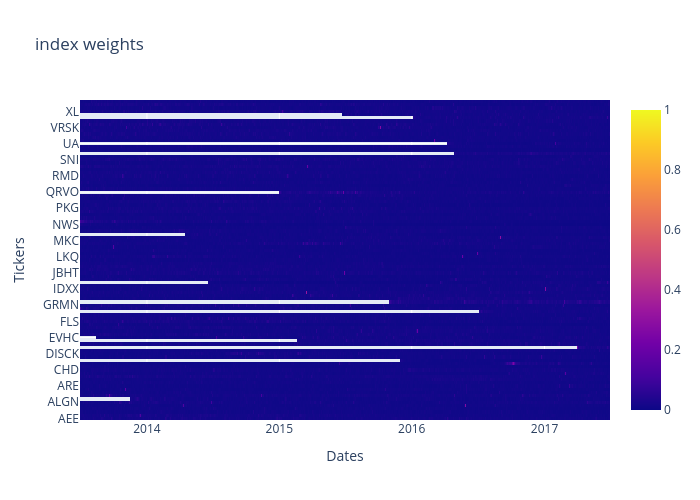

In [4]:
trace = go.Heatmap(
        x=index_weights.index,
        y=index_weights.columns,
        z=index_weights.values.T,
        zauto=False,
        zmax=1,
        zmin=0,
        hoverinfo='text')

layout = go.Layout(
        title='index weights',
        xaxis={'title': 'Dates'},
        yaxis={'title': 'Tickers'})

fig = go.Figure(data=[trace], layout=layout)

# figure is heavy to render therefore we save it to a file
# offline_py.plot(fig,filename=f'../graphs/index_weights.html')


pio.write_image(fig, '../graphs/index_weights.png')
Image('../graphs/index_weights.png')

### Portfolio Weights

Now that we have the index weights, let's choose the portfolio weights based on dividend. You would normally calculate the weights based on trailing dividend yield, but we'll simplify this by just calculating the total dividend yield over time. 


In [5]:
def calculate_dividend_weights(dividends):
    """
    Calculate dividend weights.

    Parameters
    ----------
    dividends : DataFrame
        Dividend for each stock and date

    Returns
    -------
    dividend_weights : DataFrame
        Weights for each stock and date
    """
    # dividend yields for each stock and each day
    # formula: get cumulative sum of dividends for each stock till each day then divide by total cumulative sum of all dividents for all tickers received till that day. 
    dividend_weights = (dividends.cumsum(axis=0).T/dividends.cumsum(axis=0).sum(axis=1)).T

    return dividend_weights

etf_weights = calculate_dividend_weights(dividends)


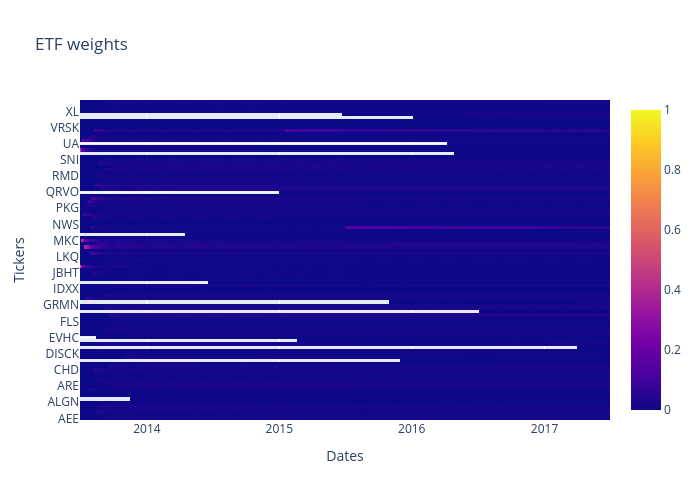

In [6]:
trace = go.Heatmap(
        x=etf_weights.index,
        y=etf_weights.columns,
        z=etf_weights.values.T,
        zauto=False,
        zmax=1,
        zmin=0)   

layout = go.Layout(
        title='ETF weights',
        xaxis={'title': 'Dates'},
        yaxis={'title': 'Tickers'})

fig = go.Figure(data=[trace], layout=layout)

# figure is heavy to render therefore we save it to a file
# offline_py.plot(fig,filename=f'../graphs/etf_weights.html')
pio.write_image(fig, '../graphs/etf_weights.png')
Image('../graphs/etf_weights.png')

### Returns

Implement generate_returns to generate returns data for all the stocks and dates from price data. You might notice we're implementing returns and not log returns. Since we're not dealing with volatility, we don't have to use log returns.

In [7]:
def generate_returns(prices):
    """
    Generate returns for ticker and date.

    Parameters
    ----------
    prices : DataFrame
        Price for each ticker and date

    Returns
    -------
    returns : Dataframe
        The returns for each ticker and date
    """
    Returns = (prices - prices.shift(1)) / prices.shift(1)

    return Returns

returns = generate_returns(close)


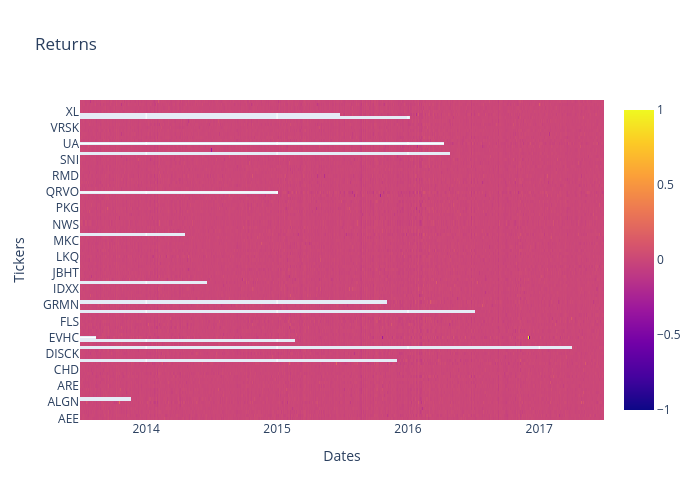

In [8]:
# plot returns

trace = go.Heatmap(
        x=returns.index,
        y=returns.columns,
        z=returns.values.T,
        zauto=False,
        zmax=1,
        zmin=-1)   

layout = go.Layout(
        title='Returns',
        xaxis={'title': 'Dates'},
        yaxis={'title': 'Tickers'})

fig = go.Figure(data=[trace], layout=layout)

# figure is heavy to render therefore we save it to a file
# offline_py.plot(fig,filename=f'../graphs/returns.html')
pio.write_image(fig, '../graphs/returns.png')
Image('../graphs/returns.png')

In [9]:
def generate_weighted_returns(returns, weights):
    """
    Generate weighted returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    weights : DataFrame
        Weights for each ticker and date

    Returns
    -------
    weighted_returns : DataFrame
        Weighted returns for each ticker and date
    """
    assert returns.index.equals(weights.index)
    assert returns.columns.equals(weights.columns)
    
    weighted_returns = returns * weights

    return weighted_returns

index_weighted_returns = generate_weighted_returns(returns, index_weights)
etf_weighted_returns = generate_weighted_returns(returns, etf_weights)

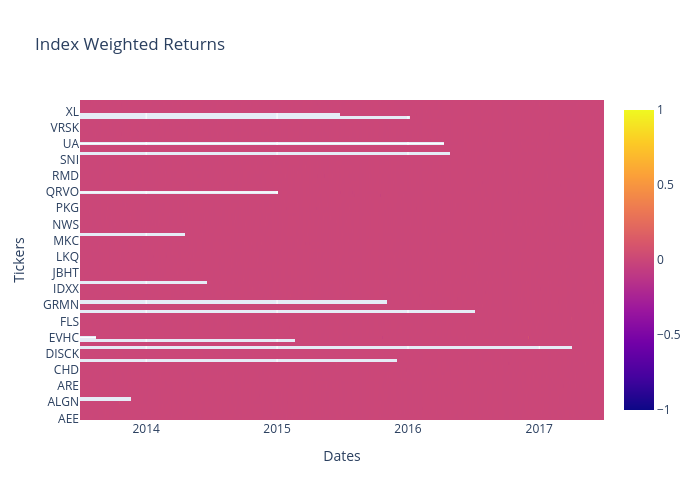

In [10]:
# plot weighted returns

trace = go.Heatmap(
        x=index_weighted_returns.index,
        y=index_weighted_returns.columns,
        z=index_weighted_returns.values.T,
        zauto=False,
        zmax=1,
        zmin=-1)   

layout = go.Layout(
        title='Index Weighted Returns',
        xaxis={'title': 'Dates'},
        yaxis={'title': 'Tickers'})

fig = go.Figure(data=[trace], layout=layout)

# figure is heavy to render therefore we save it to a file
# offline_py.plot(fig,filename=f'../graphs/index_weighted_returns.html')
pio.write_image(fig, '../graphs/index_weighted_returns.png')
Image('../graphs/index_weighted_returns.png')

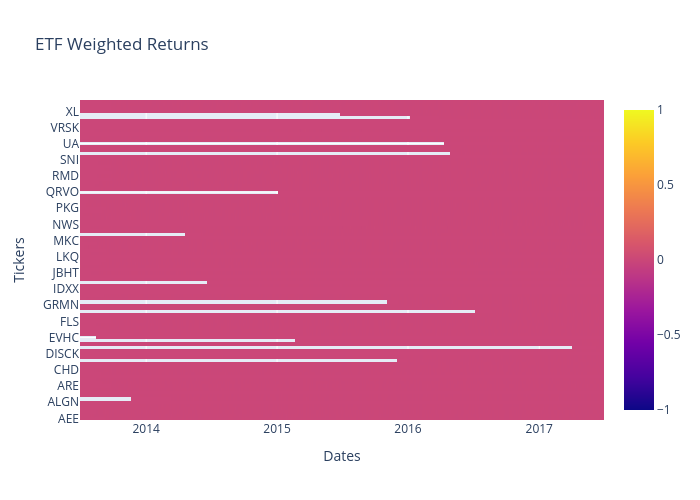

In [11]:
# plot etf weighted returns

trace = go.Heatmap( 
        x=etf_weighted_returns.index,
        y=etf_weighted_returns.columns,
        z=etf_weighted_returns.values.T,
        zauto=False,
        zmax=1,
        zmin=-1)

layout = go.Layout(
        title='ETF Weighted Returns',
        xaxis={'title': 'Dates'},
        yaxis={'title': 'Tickers'})

fig = go.Figure(data=[trace], layout=layout)

# figure is heavy to render therefore we save it to a file
# offline_py.plot(fig,filename=f'../graphs/etf_weighted_returns.html')
pio.write_image(fig, '../graphs/etf_weighted_returns.png')
Image('../graphs/etf_weighted_returns.png')

### Cummulative Returns

To compare performance between the ETF and Index, we're going to calculate the tracking error. Before we do that, we first need to calculate the index and ETF comulative returns. Implement calculate_cumulative_returns to calculate the cumulative returns over time given the returns.


In [12]:
def calculate_cumulative_returns(returns):
    """
    Calculate cumulative returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date, with dates as the index.

    Returns
    -------
    cumulative_returns : DataFrame
        Cumulative returns for each ticker and date
    """
    
    # sum all the columns in returns min_count=1 to keep NaN values
    sum_ret = returns.sum(axis=1, min_count=1)
    # add 1 to all elements in sum_ret
    sum_ret = sum_ret + 1
    # obtain the cumulative returns using np.cumprod() function with axis=0
    # for each column for each date
    cumulative_returns = np.cumprod(sum_ret, axis=0)
    return cumulative_returns

index_weighted_cumulative_returns = calculate_cumulative_returns(index_weighted_returns)
etf_weighted_cumulative_returns = calculate_cumulative_returns(etf_weighted_returns)


In [13]:
index_trace = go.Scatter(
        name='Index',
        x=index_weighted_cumulative_returns.index,
        y=index_weighted_cumulative_returns)
etf_trace = go.Scatter(
        name='ETF',
        x=etf_weighted_cumulative_returns.index,
        y=etf_weighted_cumulative_returns)

layout = go.Layout(
        title='ETF/Index Weighted Cumulative Returns',
        xaxis={'title': 'Date'},
        yaxis={'title': 'Cumulative Returns', 'range': [0, 3]})

fig = go.Figure(data=[index_trace, etf_trace], layout=layout)
offline_py.iplot(fig)

We observe that the ETF is performing better than the index.

### Tracking Error

In order to check the performance of the smart beta portfolio, we can calculate the annualized tracking error against the index. Implement tracking_error to return the tracking error between the ETF and benchmark.

For reference, we'll be using the following annualized tracking error function:

$TE = \sqrt(252)\times \sigma (r_{ETF} - r_{Index})$

Where 
 is the portfolio/ETF returns and 
 is the benchmark returns.

Note: When calculating the sample standard deviation, the delta degrees of freedom is 1, which is the also the default value.

In [14]:
def tracking_error(benchmark_returns_by_date, etf_returns_by_date):
    """
    Calculate the tracking error.

    Parameters
    ----------
    benchmark_returns_by_date : Pandas Series
        The benchmark returns for each date
    etf_returns_by_date : Pandas Series
        The ETF returns for each date

    Returns
    -------
    tracking_error : float
        The tracking error
    """
    assert benchmark_returns_by_date.index.equals(etf_returns_by_date.index)

    # calculate the tracking error
    tracking_error = np.sqrt(252)*np.std(etf_returns_by_date - benchmark_returns_by_date,ddof=1)
    
    return tracking_error

    
smart_beta_tracking_error = tracking_error(np.sum(index_weighted_returns, 1), np.sum(etf_weighted_returns, 1))

print(f"smart beta tracking error: {smart_beta_tracking_error}")

smart beta tracking error: 0.07629205601978992


The tracking error is 0.07

## Portfolio Optimization

Now, let's create a second portfolio.  We'll still reuse the market cap weighted index, but this will be independent of the dividend-weighted portfolio that we created in part 1.
We want to both minimize the portfolio variance and also want to closely track a market cap weighted index.  In other words, we're trying to minimize the distance between the weights of our portfolio and the weights of the index.

$Minimize \left [ \sigma^2_p + \lambda \sqrt{\sum_{1}^{m}(weight_i - indexWeight_i)^2} \right  ]$ 

where $m$ is the number of stocks in the portfolio, and $\lambda$ is a scaling factor that you can choose.

Why are we doing this? One way that investors evaluate a fund is by how well it tracks its index. The fund is still expected to deviate from the index within a certain range in order to improve fund performance.  A way for a fund to track the performance of its benchmark is by keeping its asset weights similar to the weights of the index.  We’d expect that if the fund has the same stocks as the benchmark, and also the same weights for each stock as the benchmark, the fund would yield about the same returns as the benchmark. By minimizing a linear combination of both the portfolio risk and distance between portfolio and benchmark weights, we attempt to balance the desire to minimize portfolio variance with the goal of tracking the index.

### Covariance Matrix


In [15]:
def get_covariance_returns(returns):
    """
    Calculate covariance matrices.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date

    Returns
    -------
    returns_covariance  : 2 dimensional Ndarray
        The covariance of the returns
    """
    # fill nan with 0 from returns 
    returns = returns.fillna(0)
    # get the covariance
    returns_covariance = np.cov(returns.T)
    
    return returns_covariance

project_test3.test_get_covariance_returns(get_covariance_returns)

Tests Passed


The formula for calculating the correlation matrix $ R $ from the covariance matrix $ \Sigma $ using the diagonal matrix of standard deviations $ D $ can be expressed in LaTeX as follows:

$
R = D^{-1} \Sigma D^{-1}
$

Here:

- $ R $ is the correlation matrix.
- $ \Sigma $ is the covariance matrix.
- $ D $ is the diagonal matrix of standard deviations, where each diagonal element \( D_{ii} \) is the standard deviation of the corresponding variable.
- $ D^{-1} $ is the inverse of the diagonal matrix of standard deviations.

This formula standardizes the covariance values, resulting in the correlation matrix.

In [16]:
covariance_returns = get_covariance_returns(returns)

# crreate a dataframe from the covariance
covariance_returns = pd.DataFrame(covariance_returns, index=returns.columns, columns=returns.columns)

# get correlation matrix
covariance_returns_correlation = np.linalg.inv(np.diag(np.sqrt(np.diag(covariance_returns))))

# create the correlation dataframe
covariance_returns_correlation = pd.DataFrame(
    covariance_returns_correlation.dot(covariance_returns).dot(covariance_returns_correlation),
    covariance_returns.index,
    covariance_returns.columns)



### portfolio variance
We can write the portfolio variance $\sigma^2_p = \mathbf{x^T} \mathbf{P} \mathbf{x}$

Recall that the $\mathbf{x^T} \mathbf{P} \mathbf{x}$ is called the quadratic form.
We can use the cvxpy function `quad_form(x,P)` to get the quadratic form.

### Distance from index weights
We want portfolio weights that track the index closely.  So we want to minimize the distance between them.
Recall from the Pythagorean theorem that you can get the distance between two points in an x,y plane by adding the square of the x and y distances and taking the square root.  Extending this to any number of dimensions is called the L2 norm.  So: $\sqrt{\sum_{1}^{n}(weight_i - indexWeight_i)^2}$  Can also be written as $\left \| \mathbf{x} - \mathbf{index} \right \|_2$.  There's a cvxpy function called [norm()](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#norm)
`norm(x, p=2, axis=None)`.  The default is already set to find an L2 norm, so you would pass in one argument, which is the difference between your portfolio weights and the index weights.

### objective function
We want to minimize both the portfolio variance and the distance of the portfolio weights from the index weights.
We also want to choose a `scale` constant, which is $\lambda$ in the expression. 

$\mathbf{x^T} \mathbf{P} \mathbf{x} + \lambda \left \| \mathbf{x} - \mathbf{index} \right \|_2$


This lets us choose how much priority we give to minimizing the difference from the index, relative to minimizing the variance of the portfolio.  If you choose a higher value for `scale` ($\lambda$).

We can find the objective function using cvxpy `objective = cvx.Minimize()`.  Can you guess what to pass into this function?



### constraints
We can also define our constraints in a list.  For example, you'd want the weights to sum to one. So $\sum_{1}^{n}x = 1$.  You may also need to go long only, which means no shorting, so no negative weights.  So $x_i >0 $ for all $i$. you could save a variable as `[x >= 0, sum(x) == 1]`, where x was created using `cvx.Variable()`.

### optimization
So now that we have our objective function and constraints, we can solve for the values of $\mathbf{x}$.
cvxpy has the constructor `Problem(objective, constraints)`, which returns a `Problem` object.

The `Problem` object has a function solve(), which returns the minimum of the solution.  In this case, this is the minimum variance of the portfolio.

It also updates the vector $\mathbf{x}$.

We can check out the values of $x_A$ and $x_B$ that gave the minimum portfolio variance by using `x.value`

In [38]:
import cvxpy as cvx

def get_optimal_weights(covariance_returns, index_weights, scale=2.0):
    """
    Find the optimal weights.

    Parameters
    ----------
    covariance_returns : 2 dimensional Ndarray
        The covariance of the returns
    index_weights : Pandas Series
        Index weights for all tickers at a period in time
    scale : int
        The penalty factor for weights the deviate from the index 
    Returns
    -------
    x : 1 dimensional Ndarray
        The solution for x
    """
    assert len(covariance_returns.shape) == 2
    assert len(index_weights.shape) == 1
    assert covariance_returns.shape[0] == covariance_returns.shape[1]  == index_weights.shape[0]

    x = cvx.Variable(len(index_weights))

    # portfolio variance
    portfolio_variance = cvx.quad_form(x, covariance_returns)

    # euclidean distance (L2 norm) between portfolio and index weights
    distance_to_index = cvx.norm(x - index_weights, 2)

    # objective function to minimize the portfolio variance and the distance to the index
    objective = cvx.Minimize(portfolio_variance + scale * distance_to_index)

    # constraints all weights must be positive and sum to 1
    constraints = [x >= 0, sum(x) == 1]

    # defining the problem
    problem = cvx.Problem(objective, constraints)

    # run the solver
    problem.solve()
    
    # get the optimal weights
    x_values = x.value
    
    return x_values


project_test3.test_get_optimal_weights(get_optimal_weights)

Tests Passed


## Optimized Portfolio

Using the `get_optimal_weights` function, let's generate the optimal ETF weights without rebalanceing. We can do this by feeding in the covariance of the entire history of data. We also need to feed in a set of index weights. We'll go with the average weights of the index over time.

In [39]:

# get the optimal weights
raw_optimal_single_rebalance_etf_weights = get_optimal_weights(covariance_returns.values, index_weights.iloc[-1])

# create a dataframe from the optimal weights   
# use tile to repeat the weights for all dates
optimal_single_rebalance_etf_weights = pd.DataFrame(
    np.tile(raw_optimal_single_rebalance_etf_weights, (len(returns.index), 1)),
    returns.index,
    returns.columns)

With our ETF weights built, let's compare it to the index. Run the next cell to calculate the ETF returns and compare it to the index returns.

In [40]:
optim_etf_returns = generate_weighted_returns(returns, optimal_single_rebalance_etf_weights)

optim_etf_cumulative_returns = calculate_cumulative_returns(optim_etf_returns)


In [41]:
# Plot bechmark and ETF cumulative returns

index_trace = go.Scatter(
        name='Index',
        x=index_weighted_cumulative_returns.index,
        y=index_weighted_cumulative_returns)
etf_trace = go.Scatter(
        name='ETF',
        x=optim_etf_cumulative_returns.index,
        y=optim_etf_cumulative_returns)

layout = go.Layout(
        title='ETF/Index Weighted Cumulative Returns',
        xaxis={'title': 'Date'},
        yaxis={'title': 'Cumulative Returns', 'range': [0, 3]})

fig = go.Figure(data=[index_trace, etf_trace], layout=layout)
offline_py.iplot(fig)


In [42]:

optim_etf_tracking_error = tracking_error(np.sum(index_weighted_returns, 1), np.sum(optim_etf_returns, 1))
print('Optimized ETF Tracking Error: {}'.format(optim_etf_tracking_error))

Optimized ETF Tracking Error: 0.05410014070940579


The tracking error has reduced from 0.07 to 0.05

## Rebalance Portfolio Over Time
The single optimized ETF portfolio used the same weights for the entire history. This might not be the optimal weights for the entire period. Let's rebalance the portfolio over the same period instead of using the same weights. Implement `rebalance_portfolio` to rebalance a portfolio.

Reblance the portfolio every n number of days, which is given as `shift_size`. When rebalancing, you should look back a certain number of days of data in the past, denoted as `chunk_size`. Using this data, compute the optimal weights using `get_optimal_weights` and `get_covariance_returns`.

In [153]:
def rebalance_portfolio(returns, index_weights, shift_size, chunk_size):
    """
    Get weights for each rebalancing of the portfolio.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    index_weights : DataFrame
        Index weight for each ticker and date
    shift_size : int
        The number of days between each rebalance
    chunk_size : int
        The number of days to look in the past for rebalancing

    Returns
    -------
    all_rebalance_weights  : list of Ndarrays
        The ETF weights for each point they are rebalanced
    """
    assert returns.index.equals(index_weights.index)
    assert returns.columns.equals(index_weights.columns)
    assert shift_size > 0
    assert chunk_size >= 0

    # print(returns.shape,shift_size,chunk_size)

    all_rebalance_weights = []
    # compute the number of chunks for making the calculations
    number_chunks = ((returns.shape[0]-chunk_size)//shift_size) + 1

    # loop over all the chunks
    # final_pos contains location of slider
    for i in range(number_chunks):
        if i == 0:
            # for first rebalance final_pos is chunk_size
            final_pos = chunk_size
        else:
            # for others it will be shifted by additive shift_size
            final_pos += shift_size

        # compute initial chunk position
        init_chunk_pos = final_pos - chunk_size
        
        # obtain the chunk to compute the returns
        ret_chunk = returns[init_chunk_pos:final_pos]
        
        # obtain the index weights for the chunk
        ind_chunk = index_weights.loc[returns.index[final_pos - 1]]
        # calculate covariance matrix
        cov = get_covariance_returns(ret_chunk)
        # get the optimal weights
        x = get_optimal_weights(cov, ind_chunk)

        # append to the list
        if x is not None:
            all_rebalance_weights.append(x)

    return all_rebalance_weights
    
    
project_test3.test_rebalance_portfolio(rebalance_portfolio)

Tests Passed


In [154]:
# get all rebalance weights
chunk_size = 250
shift_size = 5
all_rebalance_weights = rebalance_portfolio(returns, index_weights, shift_size, chunk_size)


## Portfolio Turnover
With the portfolio rebalanced, we need to use a metric to measure the cost of rebalancing the portfolio. Implement `get_portfolio_turnover` to calculate the annual portfolio turnover. We'll be using the formulas used in the classroom:

$ AnnualizedTurnover =\frac{SumTotalTurnover}{NumberOfRebalanceEvents} * NumberofRebalanceEventsPerYear $

$ SumTotalTurnover =\sum_{t,n}{\left | x_{t,n} - x_{t+1,n} \right |} $ Where $ x_{t,n} $ are the weights at time $ t $ for equity $ n $.

$ SumTotalTurnover $ is just a different way of writing $ \sum \left | x_{t_1,n} - x_{t_2,n} \right | $

In [156]:
def get_portfolio_turnover(all_rebalance_weights, shift_size, rebalance_count, n_trading_days_in_year=252):
    """
    Calculage portfolio turnover.

    Parameters
    ----------
    all_rebalance_weights : list of Ndarrays
        The ETF weights for each point they are rebalanced
    shift_size : int
        The number of days between each rebalance
    rebalance_count : int
        Number of times the portfolio was rebalanced
    n_trading_days_in_year: int
        Number of trading days in a year

    Returns
    -------
    portfolio_turnover  : float
        The portfolio turnover
    """
    assert shift_size > 0
    assert rebalance_count > 0
    
    sumtotal = 0
    # loop through each rebalance and get absolute difference in weights
    for i in range(len(all_rebalance_weights) - 1):
        sumtotal += np.abs(all_rebalance_weights[i+1] - all_rebalance_weights[i])
    # add all the difference in weights for each asset
    sumtotal  = sumtotal.sum()
    
    portfolio_turnover = (sumtotal / (rebalance_count))*(n_trading_days_in_year/shift_size)
    
    return portfolio_turnover

project_test3.test_get_portfolio_turnover(get_portfolio_turnover)

Tests Passed


In [157]:
print(get_portfolio_turnover(all_rebalance_weights, shift_size, len(all_rebalance_weights) - 1))

19.649289453652834


The annualised cost for carrying rebalacing would be 19.649. This matrix can be used to decide when to rebalance the portfolio.